In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
DENSE = False
EPS = 120
LAG = 24 + 1
SROUTE = [
    '400860-400861', 
    '400861-403781',
#     '400861-400948',
    '400861-405376',
]
HSIZE = 128
STOPS = len(SROUTE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
dset = SpotHistory(SROUTE, 'train', 32, lag=LAG, res=10).generator()
evalset = SpotHistory(SROUTE, 'test', 32, lag=LAG, res=10).generator()

Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
    * [400861-403781]: 90
    * [400861-405376]: 90
 [*] Examples (train): 10227
 [*] Time range: 2014-08-01 ~ 2014-10-31
Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
    * [400861-403781]: 90
    * [400861-405376]: 90
 [*] Examples (test): 10227
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [5]:
from models.temporal.RNN import *
# lag = 6th timestep is predicted based on past 5 (50 mins
if not DENSE:
    model = RNN_MIN(hidden_size=HSIZE, steps=STOPS).to(device)
else:
    model = RNN(hidden_size=HSIZE, steps=STOPS).to(device)
model.device = device

In [14]:
criterion, opt, sch = model.params(lr=0.001)

In [6]:
# batch x timesteps x location
evf = lambda: evaluate(
    evalset, model, crit=lambda _y, y: criterion(_y[:, :, 0], y[:, :, 0]).item())
_ = evf()

Eval loss: 116.02896           


In [18]:
losses = []
eval_mse = []
eval_mape = []
from numpy.random import randint
for eii  in range(EPS):
    bls = []
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        bls.append(loss.item())
        sys.stdout.write('[%d/%d : %d/%d] - L%.2f %s      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item(),
            '(avg %.2f)' % (10 ** 2 * np.mean(bls)) if bii == len(dset) -1 else ''
        ))
        

    sys.stdout.write('\n')
    eval_mse.append(evf())
    sys.stdout.flush()
    sch.step()

[1/120 : 320/320] - L0.19 (avg 0.21)      
Eval loss: 0.20137           
[2/120 : 320/320] - L0.15 (avg 0.21)      
Eval loss: 0.20136           
[3/120 : 320/320] - L0.17 (avg 0.21)      
Eval loss: 0.20139           
[4/120 : 320/320] - L0.16 (avg 0.21)      
Eval loss: 0.20125           
[5/120 : 320/320] - L0.17 (avg 0.21)      
Eval loss: 0.20129           


Process Process-1015:
Traceback (most recent call last):


  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()


KeyboardInterrupt: 

Process Process-1016:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 104, in get
    if timeout < 0 or not self._poll(timeout):
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwa

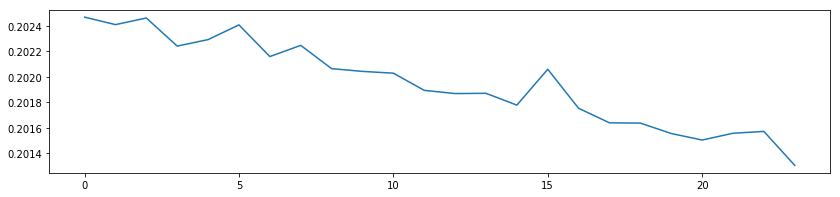

In [17]:
plt.figure(figsize=(14, 3))
plt.plot(eval_mse)
plt.show(); plt.close()

In [19]:
from utils import *
viewset = SpotHistory(SROUTE, 'test', 18, lag=None, res=10, shuffle=False, verbose=False)

sqerr = eval_rnn(viewset, model, plot=False)
print('Eval segments:', len(viewset))
print('Eval MSE: %.4f' % np.mean(sqerr))

Eval segments: 18
Eval MSE: 0.2529


Conditional Forecast


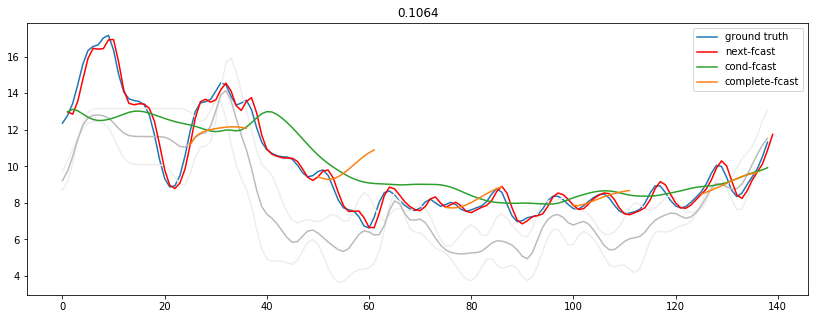

In [30]:
_ = eval_rnn(
    viewset[:1], model, 
    flag=LAG, fmax=12,
    plot=True)

In [31]:
# torch.save(model.state_dict(), 'checkpoints/rnn_thin_n2.pth')